# Choose unambiguous sketches

This notebook is for choosing sketches drawn by humans from [Google's "Quick, Draw!" dataset](https://quickdraw.withgoogle.com/data)
These stimuli were used as stimuli for my dissertation project in Dartmouth College's Department of Psychological and Brain Sciences

Dependencies: [Tensorflow](https://www.tensorflow.org/install) and [Magenta](https://github.com/tensorflow/magenta). 
Also probably a good idea to run this notebook in the choose-stimuli conda environment (.yml file included in this repo)

In [1]:
# imports for system and file management
import sys
import os
import json
import glob
import warnings

sketch_morph_path = os.getcwd()

import tensorflow as tf
import numpy as np
import pandas as pd
from itertools import product
from six.moves import map, zip

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from matplotlib.path import Path
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

# set numpy output
np.set_printoptions(precision=8, 
                    edgeitems=6, 
                    linewidth=200, 
                    suppress=True)

# Use inine display for animations
rc('animation', html='html5')

# get tools from magenta
from magenta.models.sketch_rnn.utils import *

# get tools for image editing and set DPI
from PIL import Image, ImageEnhance
my_dpi = 192

/anaconda3/envs/choose-stim/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/envs/choose-stim/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/envs/choose-stim/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/envs/choose-stim/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/envs/choose-stim/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dty

Many thanks to Louis Tiao for providing some of these functions and in [his excellent blog post](http://louistiao.me/notes/exploring-the-google-quickdraw-dataset-with-sketchrnn-part-1/) about using the Quick, Draw! dataset

In [2]:
# define some classes and functions for making stimuli
class SketchPath(Path):
    
    def __init__(self, data, factor=.2, *args, **kwargs):
        
        vertices = np.cumsum(data[::, :-1], axis=0) / factor
        codes = np.roll(self.to_code(data[::,-1].astype(int)), 
                        shift=1)
        codes[0] = Path.MOVETO

        super(SketchPath, self).__init__(vertices, 
                                         codes, 
                                         *args, 
                                         **kwargs)
        
    @staticmethod
    def to_code(cmd):
        # if cmd == 0, the code is LINETO
        # if cmd == 1, the code is MOVETO (which is LINETO - 1)
        return Path.LINETO - cmd
    
    
def draw(sketch_data, factor=.2, pad=(10, 10), ax=None, facecolor=(1.,1.,1.,0.)):

    if ax is None:
        ax = plt.gca()

    x_pad, y_pad = pad
    
    x_pad //= 2
    y_pad //= 2
        
    x_min, x_max, y_min, y_max = get_bounds(data=sketch_data,
                                            factor=factor)
    
    ax.set_xlim(x_min-x_pad, x_max+x_pad)
    ax.set_ylim(y_max+y_pad, y_min-y_pad)

    sketch = SketchPath(sketch_data)

    patch = patches.PathPatch(sketch, facecolor=(1.,1.,1.,0.))
    ax.add_patch(patch)

    return

The following assumes that you have run the generate_candidates_unambiguous.py script in the repository to save all of the sketches in the test set for each category in the hyper/datasets/ directory. The npz file that is produced in the sstimulus/ directory also contains the amount of black "ink" in each sketch

In [3]:
# get the test set sketches and pixel counts for each category
sketch_dict = {}
dict_pix = {}
categories = []
pixel_counts = []
for file in glob.glob(os.path.join(sketch_morph_path, 'stimuli','candidates_unambiguous', '*.npz')):
    file_npz = np.load(file)
    category = file.split('/')[-1].split('.')[0]
    categories.append(category)
    sketch_dict[category] = file_npz['sketches']
    dict_pix[category] = file_npz['pix_count']
    pixel_counts.append(file_npz['pix_count'])

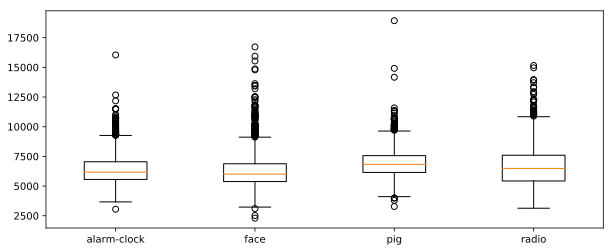

In [7]:
fig, ax = plt.subplots(figsize=(10,4));
ax.boxplot(pixel_counts, labels=categories);
plt.savefig(os.path.join(sketch_morph_path, 'pixel_counts.png'), format='png')


Next, we find the mean pixel count across categories and use a range around that for paring down test images

In [8]:
grand_mean = np.mean(pixel_counts)
st_dev = np.std(pixel_counts)
upper_limit = grand_mean + .25*st_dev
lower_limit = grand_mean - .25*st_dev
print('lower limit: {} | upper limit: {}'.format(lower_limit,upper_limit))

lower limit: 6205.606151405584 | upper limit: 6894.964571731671


In [9]:
df_pix = pd.DataFrame(dict_pix)

Create a dataframe with pixel counts for all of the test images for each category

In [10]:
df_pix.head()

,alarm-clock,face,pig,radio
0,5307.811765,7085.262745,8266.866667,6878.478431
1,5653.250980,8564.172549,6487.015686,4750.729412
2,4910.407843,6489.356863,6398.803922,7472.733333
3,7913.678431,5567.313725,5815.752941,9311.286275
4,7638.443137,4603.650980,6944.023529,4856.176471


How many sketches in each category fit our criteria?

In [11]:
for category in categories:
    df_pix[category+'mask'] = df_pix[category].apply(lambda x: upper_limit > x > lower_limit)
    print('category: %15s | No. sketches: %4d'%(category, sum(df_pix[category+'mask'])))

category:     alarm-clock | No. sketches:  503
category:            face | No. sketches:  459
category:             pig | No. sketches:  638
category:           radio | No. sketches:  423


Create a boolean mask for the dataframe for the sketches that fit our criteria

In [15]:
pixel_dict = {}

for category in categories:
    sketch_dict[category] = sketch_dict[category][df_pix[category+'mask'] == 1]
    pixel_dict[category] = dict_pix[category][df_pix[category+'mask'] == 1]
    

Double check that the number of sketches that we have pixel counts for is the same as the number of sketches we masked 

In [16]:
print('number of umbrella sketches in specified range: {}'.format(len(sketch_dict['face'])))
print('length of pixel dictionary (should be the same): {}'.format(len(pixel_dict['face'])))


number of umbrella sketches in specified range: 459
length of pixel dictionary (should be the same): 459


Let's see what they look like (change category as desired).

This draws the first 400 sketches from the desired category and includes the amount of black "ink" in the sketch

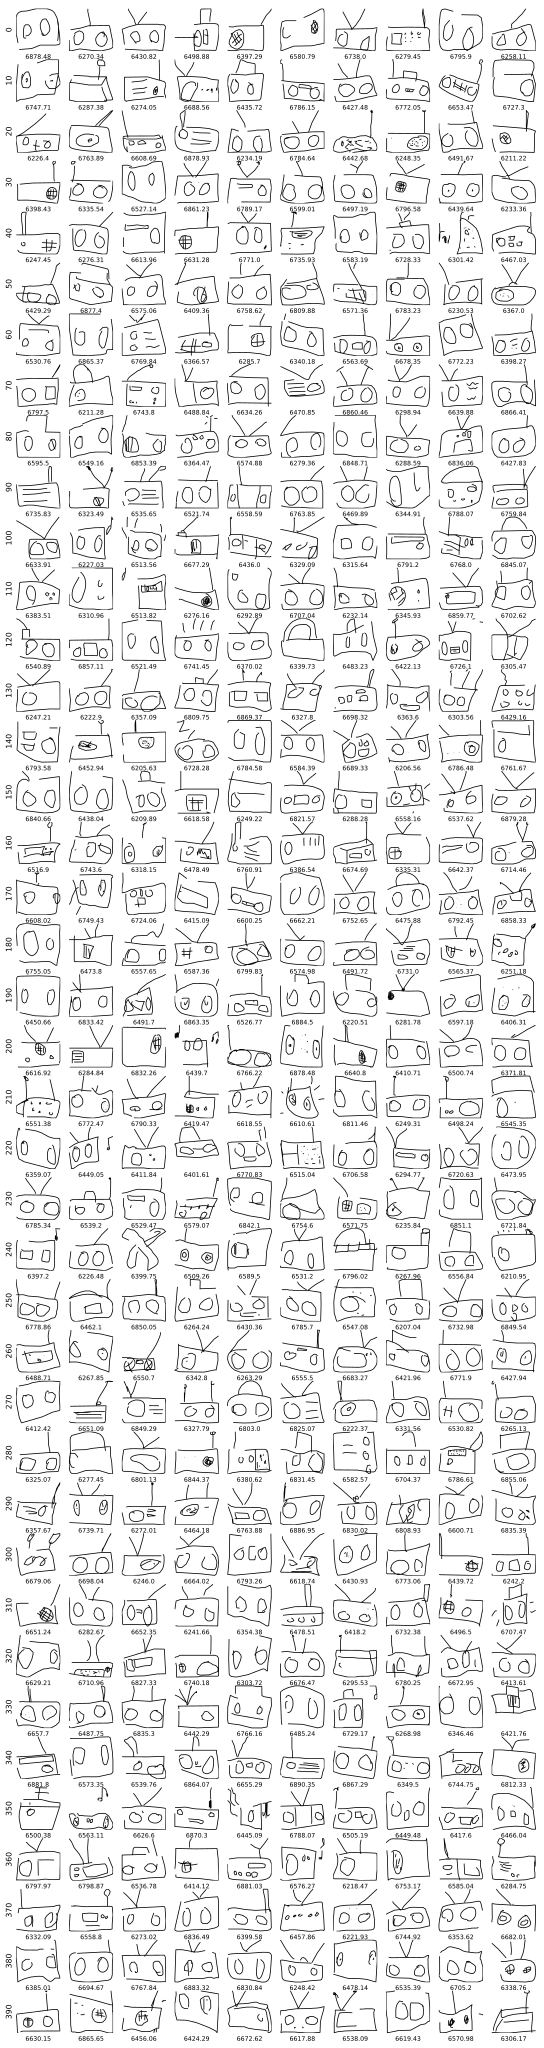

In [26]:
category= 'radio'

sketches = sketch_dict[category]
pixels = pixel_dict[category]
# draw a bunch of the candidates
fig, ax_arr = plt.subplots(nrows=40, 
                           ncols=10, 
                           figsize=(12, 48),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
# fig.tight_layout()
im_no = 0
for ax_row in ax_arr:
    for ax in ax_row:
        if im_no < 400:
            draw(sketches[im_no], ax=ax)
            ax.set_xlabel(round(pixels[im_no],2), fontsize=8)
            if im_no%10 ==0:
                ax.set_ylabel(im_no)
            im_no += 1

plt.show()

Choose which sketches to save for each category (I chose 4 each for the experiment)
My choices are already included in the repo, but going through each of the categories will overwrite them

In [27]:
#initialize these as empty lists
sketches_to_save = []
pixel_counts_to_save = []

#index of chosen sketches here
chosen = [34,111,128,294]

for sketch in chosen:
    sketches_to_save.append(sketch_dict[category][sketch])
    pixel_counts_to_save.append(pixel_dict[category][sketch])
    
np.savez(os.path.join(sketch_morph_path, 'stimuli','sketches',category+'.npz'), 
         sketches=sketches_to_save)
np.savez(os.path.join(sketch_morph_path, 'stimuli','sketches',category+'_pixelcounts.npz'),
         counts=pixel_counts_to_save)

Next, we adjust the size of each sketch so that they have  the same amount of 'ink'

In [28]:
chosen_sketch_dict = {}

for file in glob.glob(os.path.join(sketch_morph_path, 'stimuli','sketches', '*.npz')):
    if 'pixelcounts' not in file:
        chosen_sketch_dict[file.split('/')[-1].split('.')[0]] = np.load(file)['sketches']

Get ink total on white background

In [30]:
ink_totals = []
chosen_pix_dict = {}
for category in chosen_sketch_dict:
    print('doing category {}'.format(category))
    chosen_pix_dict[category]=[]
    for k, sketch in enumerate(chosen_sketch_dict[category]):
        fig, ax = plt.subplots(nrows=1,ncols=1,
                               figsize=(600/my_dpi,600/my_dpi))
        
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        draw(sketch, ax=ax)
        plt.savefig(os.path.join(sketch_morph_path, 'stimuli',
                                 'sketches','temp',
                                 category+'_temp.png'),dpi=my_dpi)        
        im = Image.open(os.path.join(sketch_morph_path, 'stimuli',
                                     'sketches','temp',
                                     category+'_temp.png')).convert('L');
        im_array = np.array(im)
        ink_total = sum(sum(1 - im_array/255))
        ink_totals.append(ink_total)
        chosen_pix_dict[category].append(ink_total)
        im.close()
    plt.close('all')

doing category radio
doing category pig
doing category alarm-clock
doing category face


In [31]:
for category in chosen_pix_dict:
    print(category)
    print(chosen_pix_dict[category])

radio
[11315.839215686272, 10222.08627450985, 11228.109803921543, 11306.69019607847]
pig
[11412.796078431342, 10757.109803921569, 10979.501960784319, 11371.113725490199]
alarm-clock
[11084.556862745101, 11190.317647058873, 11036.909803921582, 11485.48627450977]
face
[11283.443137254913, 11142.21568627446, 11186.337254901955, 11204.509803921575]


In [32]:
print('mean is {:.2f}'.format(np.mean(ink_totals)))
print('standard deviation is {:.2f}'.format(np.std(ink_totals)))
print('range is {:.2f} to {:.2f}'.format(np.min(ink_totals),np.max(ink_totals)))

mean is 11137.94
standard deviation is 292.79
range is 10222.09 to 11485.49


Match amount of black 'ink' for all sketches on white background (within 50 black pixels worth of 'ink')

In [33]:
chosen_sizes = {}
for category in chosen_sketch_dict:
    chosen_sizes[category] = []

    for k,sketch in enumerate(chosen_sketch_dict[category]):
        cycle_count = 1
        ink_total = chosen_pix_dict[category][k]
        size = 600
        while abs(ink_total-np.mean(ink_totals)) > 50:
            cycle_count += 1
            fig, ax = plt.subplots(nrows=1,ncols=1,
                                   figsize=(size/my_dpi,size/my_dpi))
            fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
            draw(sketch, ax=ax)
            plt.savefig(os.path.join(sketch_morph_path, 'stimuli',
                                     'sketches','temp',
                                     category+'_temp.png'),dpi=my_dpi)

            im = Image.open(os.path.join(sketch_morph_path, 'stimuli',
                                         'sketches','temp',
                                         category+'_temp.png')).convert('L');
            im_array = np.array(im)
            ink_total = sum(sum(1 - im_array/255))

            diff = abs(ink_total-np.mean(ink_totals))
            
            if ink_total > np.mean(ink_totals):
                size = size - np.random.rand()*10
            elif ink_total < np.mean(ink_totals):
                size = size + np.random.rand()*10
            
            plt.close('all')

            if cycle_count%20 == 0:
                print('diff is {}, resetting size to {}'.format(abs(ink_total-np.mean(ink_totals)),size))
                        
        print('finished {} sketch {}. Size is {}'.format(category,k, size))
        chosen_sizes[category].append(size)

finished radio sketch 0. Size is 585.899493356113
diff is 63.87671568625956, resetting size to 653.5961179852341
finished radio sketch 1. Size is 653.5219577526077
finished radio sketch 2. Size is 604.2904264017976
finished radio sketch 3. Size is 592.111157243005
finished pig sketch 0. Size is 583.90453693016
finished pig sketch 1. Size is 614.8933733529585
finished pig sketch 2. Size is 608.8662711763311
finished pig sketch 3. Size is 585.7470561818325
finished alarm-clock sketch 0. Size is 604.0852255916504
diff is 107.3041666667159, resetting size to 598.4409101969809
finished alarm-clock sketch 1. Size is 595.0685156331065
finished alarm-clock sketch 2. Size is 601.1294421622603
diff is 904.1389705882466, resetting size to 602.2552777605566
diff is 231.47279411763884, resetting size to 590.1676263101335
finished alarm-clock sketch 3. Size is 586.72323900303
finished face sketch 0. Size is 586.8665441946397
finished face sketch 1. Size is 600
finished face sketch 2. Size is 600
fin

In [34]:
for category in chosen_sizes:
    print(category)
    print(chosen_sizes[category])

radio
[585.899493356113, 653.5219577526077, 604.2904264017976, 592.111157243005]
pig
[583.90453693016, 614.8933733529585, 608.8662711763311, 585.7470561818325]
alarm-clock
[604.0852255916504, 595.0685156331065, 601.1294421622603, 586.72323900303]
face
[586.8665441946397, 600, 600, 601.6178252162551]


Get amount of 'ink' for resized sketches drawn on a gray background, 
accounting for the change in image size (extra_pix)

In [36]:
ink_totals_graybg = [] 
for category in chosen_sizes:
    for k, sketch in enumerate(chosen_sketch_dict[category]):
        size = chosen_sizes[category][k]
        extra_pix = size**2 - 600**2 # negative for sketches smaller than 600x600
        fig, ax = plt.subplots(nrows=1,ncols=1,
                               figsize=(size/my_dpi,size/my_dpi))
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        ax.set_facecolor((.5,.5,.5))
        fig.set_facecolor((.5,.5,.5))
        for spine in ax.spines.values():
            spine.set_edgecolor((.5,.5,.5))
        draw(sketch, ax=ax)
        plt.savefig(os.path.join(sketch_morph_path, 'stimuli',
                                 'sketches','temp',
                                 category+'_temp_gray.png'),dpi=my_dpi)

        im = Image.open(os.path.join(sketch_morph_path, 'stimuli',
                                     'sketches','temp',
                                     category+'_temp_gray.png')).convert('L');
        im_array = np.array(im)
        ink_total_graybg = sum(sum(1-im_array/255)) - (extra_pix*128)/255
        ink_totals_graybg.append(ink_total_graybg)
        
        im.save(os.path.join(sketch_morph_path,'stimuli','sketches','gray_bg',category+'_'+str(k)+'.png'), 
                format='png')

        plt.close('all')

Find stats for the resized black sketches on gray backgrounds

In [37]:
print('mean is {:.2f}'.format(np.mean(ink_totals_graybg)))
print('standard deviation is {:.2f}'.format(np.std(ink_totals_graybg)))
print('range is {:.2f} to {:.2f}'.format(np.min(ink_totals_graybg),np.max(ink_totals_graybg)))

mean is 183336.02
standard deviation is 230.86
range is 182913.30 to 183641.43


Next, we will make movies from all of the chosen sketches

In [38]:
def animate_1(i, color_frames, movie_sketch):
    if i <= len(movie_sketch):
        the_sketch = SketchPath(movie_sketch[:i+1])
        the_patch  = ax.add_patch(patches.PathPatch(the_sketch,
                                  facecolor=(.5,.5,.5), edgecolor=(0.,0.,0.)))
    else:
        the_sketch = SketchPath(movie_sketch)
        the_patch  = ax.add_patch(patches.PathPatch(the_sketch,
                                  facecolor=(.5,.5,.5), edgecolor=(0.,0.,0.)))
    
    return the_patch


def make_movie_fig(movie_sketch, size):
    # create an axis to draw a single sketch
    fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(size/my_dpi, size/my_dpi),
                           subplot_kw=dict(xticks=[],
                                           yticks=[]),
                           frameon=False)


    fig.tight_layout()

    x_pad, y_pad = 10, 10

    x_pad //= 2
    y_pad //= 2

    (x_min,
     x_max,
     y_min,
     y_max) = get_bounds(data=movie_sketch, factor=.2)

    ax.set_xlim(x_min-x_pad, x_max+x_pad);
    ax.set_ylim(y_max+y_pad, y_min-y_pad);

    # this makes the background gray
    ax.set_facecolor((.5,.5,.5)) 
    fig.set_facecolor((.5,.5,.5))
    for spine in ax.spines.values():
        spine.set_edgecolor((.5,.5,.5))
        
    return fig, ax

In [39]:
for category in chosen_sketch_dict:
    for k, sketch in enumerate(chosen_sketch_dict[category]):
        # draw the sketch at the right size
        fig, ax = make_movie_fig(sketch,chosen_sizes[category][k])
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        movie_length = 1920 # length in milliseconds
        frames = sketch.shape[0]+44 # number of frames in sketch
        interval = movie_length/(frames-1) # calculate time in between frames
        print( 'sketch category: {} \n'
               'length of movie: {}ms \n'
               'size of movie: {} \n'
               'number of frames: {} \n'
               'time between frames: {:.2f} ms'.format(category,movie_length,chosen_sizes[category][k],frames,interval))

        print('\n')

        outfile = os.path.join(sketch_morph_path,'stimuli', 'unambiguous_videos_resized', category+'_'+str(k)+'.mov')

        color_frames = np.repeat(False, frames)
        k = np.random.randint(1,frames-1)
        fargs = (color_frames,sketch)

        animation = FuncAnimation(fig,
                                  animate_1,
                                  fargs=(fargs),
                                  frames=frames,
                                  interval=interval,
                                  repeat_delay=1000*3)

        print('saving full movie ... \n')

        animation.save(outfile, codec="png",
                       dpi=my_dpi, bitrate=-1)

        plt.close('all')

sketch category: radio 
length of movie: 1920ms 
size of movie: 585.899493356113 
number of frames: 107 
time between frames: 18.11 ms


saving full movie ... 

sketch category: radio 
length of movie: 1920ms 
size of movie: 653.5219577526077 
number of frames: 102 
time between frames: 19.01 ms


saving full movie ... 

sketch category: radio 
length of movie: 1920ms 
size of movie: 604.2904264017976 
number of frames: 136 
time between frames: 14.22 ms


saving full movie ... 

sketch category: radio 
length of movie: 1920ms 
size of movie: 592.111157243005 
number of frames: 94 
time between frames: 20.65 ms


saving full movie ... 

sketch category: pig 
length of movie: 1920ms 
size of movie: 583.90453693016 
number of frames: 130 
time between frames: 14.88 ms


saving full movie ... 

sketch category: pig 
length of movie: 1920ms 
size of movie: 614.8933733529585 
number of frames: 159 
time between frames: 12.15 ms


saving full movie ... 

sketch category: pig 
length of movie

# Now we do the same for photographic images from these categories

In [40]:
# function for making square image on grayscale background
def make_square(im, min_size=600, fill_color=(128, 128, 128)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), (int((size - y) / 2))))
    return new_im

Let's remind ourselves of the mean luminance for the sketches

In [54]:
print(np.mean(ink_totals_graybg))
print(np.std(ink_totals_graybg))

182903.80657033663
220.3866331834025


In [41]:
photo_files = glob.glob(os.path.join(sketch_morph_path,'stimuli','photo','*.png'))

Change brightness of each photo until it is in the same range of luminance as the sketches

In [42]:
for file in photo_files:
    fn = file.split('/')[-1].split('.')[0]
    out_file = os.path.join(sketch_morph_path,'stimuli','photo','normalized',fn+'.png')
    im = Image.open(file).convert('L')
    im_bg = make_square(im).convert('L')
    im_array = np.array(im_bg)
    ink_total = sum(sum(1 - im_array/255))
    enhancer = ImageEnhance.Brightness(im)
    factor = 1.0
    cycle_count = 0
    while abs(ink_total-np.mean(ink_totals_graybg)) > 50:
        if ink_total > np.mean(ink_totals_graybg):
            factor = factor + np.random.rand()*0.001
            enhanced = enhancer.enhance(factor)
            enhanced_bg = make_square(enhanced).convert('L')
            enhanced_array = np.array(enhanced_bg)
            ink_total = sum(sum(1-enhanced_array/255))
        elif ink_total < np.mean(ink_totals_graybg):
            factor = factor - np.random.rand()*0.001
            enhanced = enhancer.enhance(factor)
            enhanced_bg = make_square(enhanced).convert('L')
            enhanced_array = np.array(enhanced_bg)
            ink_total = sum(sum(1-enhanced_array/255))
        else:
            print('something funny is happening')
        
        if cycle_count%1000 == 0: 
            print('working on {}'.format(fn))
            print('factor: {} | ink_total: {}'.format(factor, ink_total))
        
        cycle_count+=1
        
    print('finished {}'.format(fn))
    new_image = make_square(enhancer.enhance(factor))
    new_image.save(out_file, format='png')
    print(out_file)

working on alarm-clock_0
factor: 0.9994057464527907 | ink_total: 127708.51764705888
finished alarm-clock_0
/Users/kevinhartstein/gitrepos/quickdraw_stimulus_generation/stimuli/photo/normalized/alarm-clock_0.png
working on alarm-clock_1
factor: 1.0009911716769853 | ink_total: 204839.8745098048
finished alarm-clock_1
/Users/kevinhartstein/gitrepos/quickdraw_stimulus_generation/stimuli/photo/normalized/alarm-clock_1.png
working on alarm-clock_2
factor: 0.9995435536620643 | ink_total: 164591.3019607843
finished alarm-clock_2
/Users/kevinhartstein/gitrepos/quickdraw_stimulus_generation/stimuli/photo/normalized/alarm-clock_2.png
working on alarm-clock_3
factor: 0.9993391084700528 | ink_total: 170788.40392156967
finished alarm-clock_3
/Users/kevinhartstein/gitrepos/quickdraw_stimulus_generation/stimuli/photo/normalized/alarm-clock_3.png
working on face_0
factor: 1.0008587612937432 | ink_total: 199708.54901960766
finished face_0
/Users/kevinhartstein/gitrepos/quickdraw_stimulus_generation/stim

Great, now we have a set of luminance-matches sketches and photographs to use in the sketch experiment!